In [59]:
import importlib
from volo_tools import volo_data
import numpy as np
import pandas as pd
from volo_tools import volo_feature_impl 
importlib.reload(volo_data)
importlib.reload(volo_feature_impl)
processor = volo_data.VoloDataProcessor()
processor.process("beta_project_data.csv")
print(processor.data.head())

Stocks with adjustment factor changes:
Symbol
AAPL      1510
CELG      1127
CMCS.A    1510
CRM        827
EOG       1067
GILD       771
GOOG       272
ICE       1510
KR        1390
LBTY.K    1047
MA        1019
NFLX      1391
NKE       1500
SBUX      1324
TSLA      1388
UAA       1077
UNP       1114
V         1310
dtype: int64
         Code Symbol       Date  Close      Volume  Adjustment Factor  \
275483  59268   AABA 2010-01-04  17.10  16600000.0                1.0   
93289   59268   AABA 2010-01-05  17.23  11700000.0                1.0   
29827   59268   AABA 2010-01-06  17.17  16400000.0                1.0   
275009  59268   AABA 2010-01-07  16.70  31800000.0                1.0   
103111  59268   AABA 2010-01-08  16.70  15500000.0                1.0   

        Adj_Close  
275483      17.10  
93289       17.23  
29827       17.17  
275009      16.70  
103111      16.70  


In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
importlib.reload(volo_feature_impl)

data_dir = "data"
graph_dir = os.path.join(data_dir, "graphs")
os.makedirs(graph_dir, exist_ok=True)

csv_files = glob.glob(os.path.join(data_dir, "*.csv"))

all_betas = {}
symbol_std_list = []

for file in csv_files:
    try:
        df = pd.read_csv(file)
        if "Beta_45d" in df.columns:
            symbol = os.path.basename(file).replace("_data.csv", "")
            df = df.dropna(subset=["Beta_45d"])
            if len(df) == 0:
                continue

            all_betas[symbol] = df["Beta_45d"].values
            beta_std = df["Beta_45d"].std(skipna=True)
            symbol_std_list.append({"Symbol": symbol, "Beta_45d_STD": beta_std})
    except Exception as e:
        print(f"Error reading {file}: {e}")

In [358]:
importlib.reload(volo_feature_impl)
from sklearn.metrics import mean_squared_error, r2_score

train_window = 500
steps = 30
smoothing_window = 5

spy_data = pd.read_csv('data/SPY_data.csv')
spy_data.set_index("Date", inplace=True)
feature_processor = volo_feature_impl.VoloFeatureImpl()
spy, har_model = feature_processor._prepare_spy_baseline(spy_data, future_window=45)
spy.dropna(inplace=True)
spy["target_multiplier"] = spy["RV_future"]/spy["HAR_Pred"]
# smooth target_multiplier
spy["target_multiplier"] = spy["target_multiplier"].ewm(span=smoothing_window, adjust=False).mean()
spy.to_csv('spy_target_sanity_check.csv')
print(spy.head())
#
avg_abs_diff = np.mean(np.abs(spy["RV_future"] - spy["HAR_Pred"]))
print(avg_abs_diff)
har_mse = mean_squared_error(spy["RV_future"], spy["HAR_Pred"])
har_r2 = r2_score(spy["RV_future"], spy["HAR_Pred"])
print(har_mse)
print(har_r2)

             Code Symbol   Close       Volume  Adjustment Factor  Adj_Close  \
Date                                                                          
2010-01-05  59751    SPY  113.63  112000000.0                1.0     113.63   
2010-01-06  59751    SPY  113.71  116000000.0                1.0     113.71   
2010-01-07  59751    SPY  114.19  131000000.0                1.0     114.19   
2010-01-08  59751    SPY  114.57  126000000.0                1.0     114.57   
2010-01-11  59751    SPY  114.73  106000000.0                1.0     114.73   

            Log_Return  SPY_Return  Beta_45d  Future_Beta_45d  Variance_45d  \
Date                                                                          
2010-01-05    0.002644    0.002644       NaN              1.0           NaN   
2010-01-06    0.000704    0.000704       NaN              1.0           NaN   
2010-01-07    0.004212    0.004212       NaN              1.0           NaN   
2010-01-08    0.003322    0.003322       NaN       

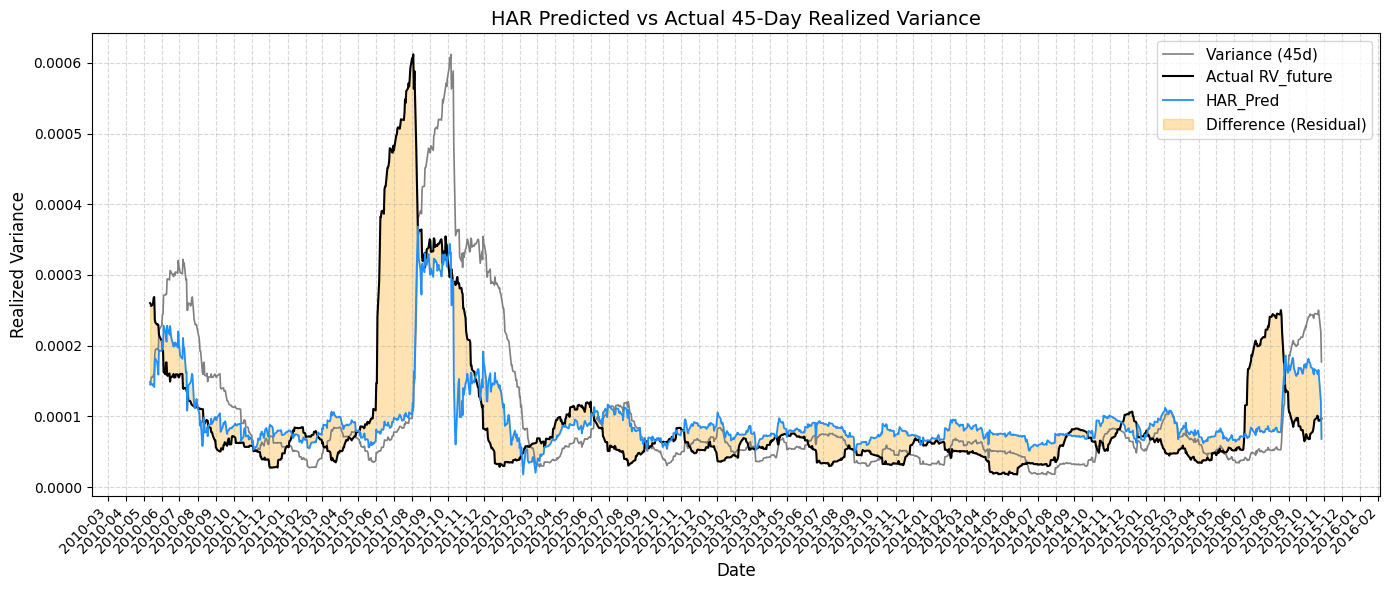

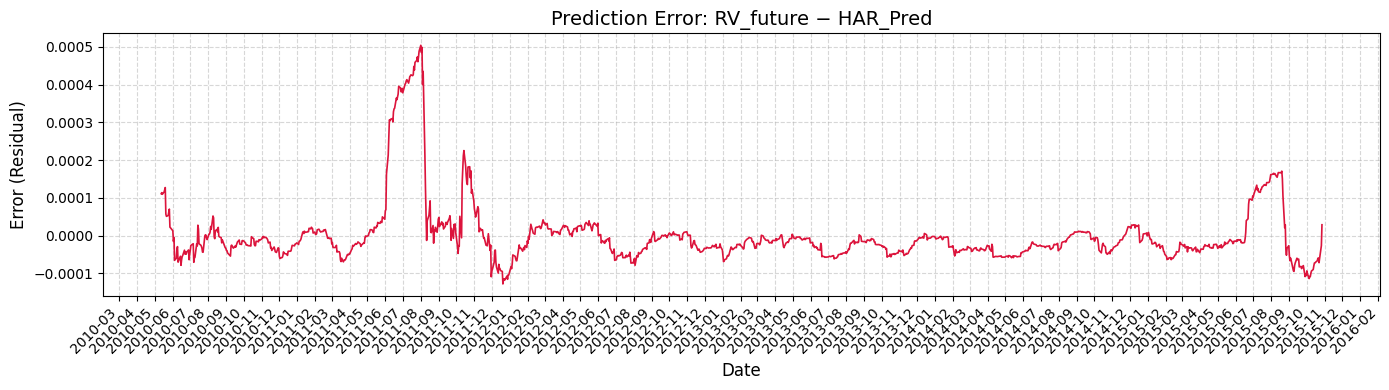

In [360]:
import matplotlib.dates as mdates
# Ensure index is datetime
if spy.index.dtype == "object" or not np.issubdtype(spy.index.dtype, np.datetime64):
    spy.index = pd.to_datetime(spy.index, errors="coerce")

spy = spy[~spy.index.isna()].sort_index()

# -----------------------------------
# Plot HAR vs RV_future and difference
# -----------------------------------
plt.figure(figsize=(14, 6))

if "Variance_45d" in spy.columns:
    plt.plot(spy.index, spy["Variance_45d"], label="Variance (45d)", color="gray", linewidth=1.2)

plt.plot(spy.index, spy["RV_future"], label="Actual RV_future", color="black", linewidth=1.5)
plt.plot(spy.index, spy["HAR_Pred"], label="HAR_Pred", color="dodgerblue", linewidth=1.3)

plt.fill_between(
    spy.index, spy["RV_future"], spy["HAR_Pred"],
    color="orange", alpha=0.3, label="Difference (Residual)"
)

plt.title("HAR Predicted vs Actual 45-Day Realized Variance", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Realized Variance", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)

ax = plt.gca()
# Use month ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

# -----------------------------------
# Residual plot
# -----------------------------------
plt.figure(figsize=(14, 4))
plt.plot(spy.index, spy["RV_future"] - spy["HAR_Pred"], color="crimson", linewidth=1.2)

plt.title("Prediction Error: RV_future − HAR_Pred", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Error (Residual)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [361]:
import os
import glob
import pandas as pd
from sklearn.decomposition import FastICA
import numpy as np

def feature_collector(all_symbols, spy_path="data/SPY_data.csv"):
    """
    Collects and merges features for a list of symbols.
    """
    if not os.path.exists(spy_path):
        raise FileNotFoundError(f"SPY data not found at {spy_path}")
    
    data = spy

    for symbol in all_symbols:
        file_path = f"data/{symbol}_data.csv"
        if not os.path.exists(file_path):
            print(f"Warning: {file_path} not found, skipping.")
            continue

        symbol_data = pd.read_csv(file_path)
        # if index is not datetime, convert it
        if symbol_data.index.dtype == "object" or not np.issubdtype(symbol_data.index.dtype, np.datetime64):
            symbol_data.index = pd.to_datetime(symbol_data.index, errors="coerce")
            symbol_data = symbol_data[~symbol_data.index.isna()]
            symbol_data = symbol_data.sort_index()
            # turn symbol_data column into index
            symbol_data.reset_index(inplace=True)
            # set as datetime
            symbol_data["Date"] = pd.to_datetime(symbol_data["Date"], errors="coerce")
            
        data = pd.merge(
            data,
            symbol_data,
            on="Date",
            how="outer",
            suffixes=("", f"_{symbol}")
        )

    data.sort_values("Date", inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    # Remove columns not needed for analysis
    data = data.loc[:, ~data.columns.str.contains('Future_Beta_45d')]
    data = data.loc[:, ~data.columns.str.contains('Code')]
    data = data.loc[:, ~data.columns.str.contains('RV_future')]
    data = data.loc[:, ~data.columns.str.contains('Symbol')]
    data = data.loc[:, ~data.columns.str.contains('Residual')]
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
        
    return data

# --- Main execution block ---

data_dir = "data/"
csv_files = glob.glob(os.path.join(data_dir, "*.csv"))

valid_symbols = [os.path.basename(f).replace("_data.csv", "") for f in csv_files if pd.read_csv(f).shape[0] > 1300]
x_variance = feature_collector(valid_symbols, spy_path="data/SPY_data.csv")

bond_etfs = [ "BND", "AGG", "TLT", "SHY" ]
etf_list = [
    "DIA", "IJH", "IBB", "IVV", "IWB", "IWD", "IWF", "IWM", "IWN", "IWR",
    "IYR", "MDY", "NFLX", "QQQ", "SPY", "V", "VLO", "VNQ", "VOO", "VTI",
    "VTV", "XOP"
]

# --- Corrected Universe-Based Rolling ICA Implementation ---

# 1. PRECISELY identify ONLY the 'Adj Close' columns for the ETF universe.
etf_set = set(etf_list) # Use a set for fast lookups
ica_input_cols = []
for col in x_variance.columns:
    # Handle suffixed columns like 'Adj Close_AGG'
    if col.startswith('Adj_Close_') and col.split('_')[-1] in etf_set:
        ica_input_cols.append(col)
    # Handle the base case for SPY, which is just 'Adj Close'
    elif col == 'Adj_Close' and 'SPY' in etf_set:
        ica_input_cols.append(col)

if not ica_input_cols:
    print("No 'Adj Close' columns for the specified ETFs were found. Exiting ICA process.")
    x_variance_final = x_variance.copy()
else:
    print(f"Found {len(ica_input_cols)} 'Adj Close' columns to use for ICA.")
    
    # 2. Define parameters and select the data for ICA
    window_size = 45
    n_components = 10 
    
    etf_data_for_ica = x_variance[ica_input_cols]
    
    # 3. Perform rolling ICA on the selected 'Adj Close' data
    ica_components_array = np.full((len(etf_data_for_ica), n_components), np.nan)
    ica = FastICA(n_components=n_components, random_state=0, max_iter=10000, tol=0.1)
    
    print(f"Processing rolling ICA...")
    for i in range(window_size, len(etf_data_for_ica) + 1):
        window = etf_data_for_ica.iloc[i - window_size:i].values
        try:
            transformed_window = ica.fit_transform(window)
            ica_components_array[i - 1] = transformed_window[-1, :]
        except Exception:
            pass

    # 4. Create a DataFrame with the new ICA component features
    ica_component_names = [f"ICA_ETF_Universe_component_{i}" for i in range(n_components)]
    ica_results_df = pd.DataFrame(ica_components_array, index=x_variance.index, columns=ica_component_names)
    
    # 5. Combine the original data with the new ICA features
    x_variance_with_ica = pd.concat([x_variance, ica_results_df], axis=1)

    # 6. CRITICAL STEP: Drop ONLY the 'Adj Close' columns that were used as input for the ICA
    print(f"Removing the {len(ica_input_cols)} 'Adj Close' columns used as ICA input.")
    x_variance_final = x_variance_with_ica.drop(columns=ica_input_cols)

    # Drop rows with NaN values created by the rolling window
    x_variance_final.dropna(inplace=True)
    x_variance = x_variance_final.copy()
    

# --- Final Output ---
print("\nDataFrame head after adding ICA components and removing ONLY the source 'Adj Close' columns:")
print(x_variance_final.head())
print(f"\nFinal DataFrame contains {x_variance_final.shape[1]} columns.")


# Ensure the results directory exists
if not os.path.exists("results"):
    os.makedirs("results")
    
x_variance_final.to_csv("results/combined_features_with_adj_close_ica.csv", index=False)

Found 23 'Adj Close' columns to use for ICA.
Processing rolling ICA...
Removing the 23 'Adj Close' columns used as ICA input.

DataFrame head after adding ICA components and removing ONLY the source 'Adj Close' columns:
         Date   Close       Volume  Adjustment Factor  Log_Return  SPY_Return  \
44 2011-03-21  129.74  154000000.0                1.0    0.015379    0.015379   
45 2011-03-22  129.29  130000000.0                1.0   -0.003475   -0.003475   
46 2011-03-23  129.66  149000000.0                1.0    0.002858    0.002858   
47 2011-03-24  130.90  159000000.0                1.0    0.009518    0.009518   
48 2011-03-25  131.30  156000000.0                1.0    0.003051    0.003051   

    Beta_45d  Variance_45d  Variance_45d_MA  Variance_5d_MA  ...  \
44       1.0      0.000085         0.000046        0.000078  ...   
45       1.0      0.000084         0.000047        0.000081  ...   
46       1.0      0.000084         0.000048        0.000082  ...   
47       1.0      0.0

In [362]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def rolling_xgb_pca_fold(
    df,
    target_col="target_multiplier",
    train_window=100,
    step=5,
    fold_interval=5,
    low_importance_ratio=0.3,
    n_pca_components=3
):
    if "Date" not in df.columns:
        if df.index.name == "Date":
            df = df.reset_index()
        else:
            raise ValueError("DataFrame must contain 'Date' column or have 'Date' as index name.")

    # numeric feature selection
    x_cols = [c for c in df.columns if c not in ["Date", target_col]]
    x_cols = [c for c in x_cols if pd.api.types.is_numeric_dtype(df[c]) and c != "Date"]

    preds, actuals, dates = [], [], []
    all_feature_importance = []
    global_importance = pd.Series(0.0, index=x_cols)
    scaler = StandardScaler()

    try:
        _ = xgb.DeviceQuantileDMatrix
        use_gpu = True
    except Exception:
        use_gpu = False

    for i, start in enumerate(range(train_window, len(df) - step, step)):
        train_set = df.iloc[start - train_window:start]
        test_set = df.iloc[start:start + step]

        X_train, y_train = train_set[x_cols], train_set[target_col]
        X_test, y_test = test_set[x_cols], test_set[target_col]

        X_train = X_train.drop(columns=["target_multiplier"], errors="ignore")
        X_test = X_test.drop(columns=["target_multiplier"], errors="ignore")

        params = dict(
            n_estimators=70,
            learning_rate=0.07,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
        )
        if use_gpu:
            params.update(tree_method="gpu_hist", predictor="gpu_predictor")
        else:
            params.update(tree_method="hist", predictor="cpu_predictor")

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

        imp = model.get_booster().get_score(importance_type="gain")
        imp_series = pd.Series(imp, dtype=float)
        imp_series = imp_series.reindex(x_cols, fill_value=0)
        global_importance = 0.9 * global_importance.add(imp_series, fill_value=0)

        all_feature_importance.append(imp_series.to_dict())
        y_pred = model.predict(X_test)
        preds.extend(y_pred)
        actuals.extend(y_test.values)
        dates.extend(df["Date"].iloc[start:start + step].values)
        
        # Periodic PCA-based feature folding
        if (i + 1) % fold_interval == 0 and len(x_cols) > 10:
            avg_imp = global_importance.copy()
            avg_imp /= avg_imp.sum()
            sorted_features = avg_imp.sort_values(ascending=True)
            low_imp_features = sorted_features.head(int(len(sorted_features) * low_importance_ratio)).index.tolist()

            if len(low_imp_features) >= n_pca_components:
                print(f"\n[PCA Fold] Window {start}: Combining {len(low_imp_features)} low-importance features into {n_pca_components} PCA components")

                pca_input = df[low_imp_features].fillna(0).values
                scaled_input = scaler.fit_transform(pca_input)
                pca = PCA(n_components=n_pca_components, random_state=42)
                pca_features = pca.fit_transform(scaled_input)

                for j in range(n_pca_components):
                    df[f"PCA_Fold_{i+1}_{j+1}"] = pca_features[:, j]

                x_cols = [c for c in x_cols if c not in low_imp_features] + [f"PCA_Fold_{i+1}_{j+1}" for j in range(n_pca_components)]
                global_importance = global_importance.loc[[f for f in global_importance.index if f in x_cols]]
                for new_f in [f for f in x_cols if f.startswith(f"PCA_Fold_{i+1}")]:
                    global_importance[new_f] = 0.1  # initialize small gain weight

    result_df = pd.DataFrame({
        "Date": pd.to_datetime(dates),
        "Actual": actuals,
        "Predicted": preds,
        # Calculate predicted variance from predicted multiplier and HAR_Pred
        "Predicted_Var_Index": preds * x_variance["HAR_Pred"]
    }).sort_values("Date").set_index("Date")

    final_importance = global_importance.sort_values(ascending=False).reset_index()
    final_importance.columns = ["Feature", "Avg_Gain"]
    final_importance.to_csv("results/feature_pca_folding_importance.csv", index=False)

    print("\n=== Final Feature Importance (Averaged) ===")
    print(final_importance.head(15).to_string(index=False))
    print(f"\nRemaining Features: {len(x_cols)}")

    return result_df, final_importance

pred_df_spy_var_pca, feature_importance_df = rolling_xgb_pca_fold(x_variance)
print(pred_df_spy_var_pca.head())

c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:36:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:36:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:36:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 120: Combining 662 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:36:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:36:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 145: Combining 464 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:36:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 170: Combining 326 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:36:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:36:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:36:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 195: Combining 229 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 220: Combining 161 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 245: Combining 114 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 270: Combining 81 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 295: Combining 57 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 320: Combining 41 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 345: Combining 30 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 370: Combining 21 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 395: Combining 16 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 420: Combining 12 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 445: Combining 9 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 470: Combining 8 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 495: Combining 6 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 520: Combining 5 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 545: Combining 5 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 570: Combining 4 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 595: Combining 4 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 620: Combining 3 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 645: Combining 3 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 670: Combining 3 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 695: Combining 3 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 720: Combining 3 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 745: Combining 3 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 770: Combining 3 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 795: Combining 3 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 820: Combining 3 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 845: Combining 3 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 870: Combining 3 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 895: Combining 3 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 920: Combining 3 low-importance features into 3 PCA components


C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\1255447732.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{i+1}_{j+1}"] = pca_features[:, j]
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-auto


[PCA Fold] Window 945: Combining 3 low-importance features into 3 PCA components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 970: Combining 3 low-importance features into 3 PCA components


C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\1255447732.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{i+1}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\1255447732.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{i+1}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\1255447732.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 


[PCA Fold] Window 995: Combining 3 low-importance features into 3 PCA components


C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\1255447732.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{i+1}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\1255447732.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{i+1}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\1255447732.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 


[PCA Fold] Window 1020: Combining 3 low-importance features into 3 PCA components


C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\1255447732.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{i+1}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\1255447732.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{i+1}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\1255447732.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 


[PCA Fold] Window 1045: Combining 3 low-importance features into 3 PCA components


C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\1255447732.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{i+1}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\1255447732.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{i+1}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\1255447732.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

ValueError: operands could not be broadcast together with shapes (955,) (1060,) 

In [183]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def rolling_xgb_pca_fold(
    df,
    target_col="target_multiplier",
    train_window=100,
    step=5,
    fold_interval=5,
    low_importance_ratio=0.3,
    n_pca_components=3,
    pca_importance_threshold=0.15,
    remerge_ratio=0.4
):
    if "Date" not in df.columns:
        if df.index.name == "Date":
            df = df.reset_index()
        else:
            raise ValueError("DataFrame must contain 'Date' column or have 'Date' as index name.")

    x_cols = [c for c in df.columns if c not in ["Date", target_col]]
    x_cols = [c for c in x_cols if pd.api.types.is_numeric_dtype(df[c]) and c != "Date"]

    preds, actuals, dates = [], [], []
    global_importance = pd.Series(0.0, index=x_cols)
    scaler = StandardScaler()
    pca_history = {}
    pca_round = 0

    try:
        _ = xgb.DeviceQuantileDMatrix
        use_gpu = True
    except Exception:
        use_gpu = False

    for i, start in enumerate(range(train_window, len(df) - step, step)):
        # --- Always sync features with dataframe ---
        x_cols = [c for c in x_cols if c in df.columns]

        train_set = df.iloc[start - train_window:start]
        test_set = df.iloc[start:start + step]

        # Skip if not enough columns
        if not x_cols:
            print(f"[WARN] No valid features at step {start}, skipping...")
            continue

        # Prepare train/test splits safely
        X_train, y_train = train_set[x_cols], train_set[target_col]
        X_test, y_test = test_set[x_cols], test_set[target_col]

        params = dict(
            n_estimators=70,
            learning_rate=0.07,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
        )
        if use_gpu:
            params.update(tree_method="gpu_hist", predictor="gpu_predictor")
        else:
            params.update(tree_method="hist", predictor="cpu_predictor")

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

        # Importance tracking
        imp = model.get_booster().get_score(importance_type="gain")
        imp_series = pd.Series(imp, dtype=float)
        imp_series = imp_series.reindex(x_cols, fill_value=0)
        global_importance = 0.9 * global_importance.add(imp_series, fill_value=0)

        preds.extend(model.predict(X_test))
        actuals.extend(y_test.values)
        dates.extend(df["Date"].iloc[start:start + step].values)

        # --- PCA SURGE CHECK ---
        pca_feats = [f for f in x_cols if f.startswith("PCA_Fold_")]
        existing_pca_feats = [f for f in pca_feats if f in df.columns]
        if existing_pca_feats:
            pca_share = global_importance[existing_pca_feats].sum() / global_importance.sum()
            if pca_share > pca_importance_threshold:
                print(f"\n[UNFOLD TRIGGER] PCA features exceed {pca_importance_threshold:.0%} importance → Refolding...")

                all_loadings = []
                for pca_f in existing_pca_feats:
                    try:
                        pca_id = pca_f.split("_")[2]
                        if pca_id in pca_history:
                            components, orig_feats = pca_history[pca_id]
                            feat_strength = pd.Series(np.abs(components).mean(axis=0), index=orig_feats)
                            all_loadings.append(feat_strength)
                    except Exception:
                        continue

                if all_loadings:
                    combined = pd.concat(all_loadings, axis=1).mean(axis=1)
                    combined.sort_values(ascending=False, inplace=True)
                    keep_feats = combined.head(int(len(combined) * remerge_ratio)).index.tolist()
                    fold_feats = combined.tail(int(len(combined) * (1 - remerge_ratio))).index.tolist()

                    df.drop(columns=existing_pca_feats, inplace=True, errors="ignore")
                    x_cols = [f for f in x_cols if f not in existing_pca_feats]

                    safe_feats = [f for f in fold_feats if f in df.columns]
                    if len(safe_feats) >= n_pca_components:
                        pca_round += 1
                        pca_input = df[safe_feats].fillna(0).values
                        scaled_input = scaler.fit_transform(pca_input)
                        pca = PCA(n_components=n_pca_components, random_state=42)
                        pca_features = pca.fit_transform(scaled_input)

                        for j in range(n_pca_components):
                            df[f"PCA_Fold_{pca_round}_{j+1}"] = pca_features[:, j]
                        pca_history[str(pca_round)] = (pca.components_, safe_feats)

                        new_cols = [f"PCA_Fold_{pca_round}_{j+1}" for j in range(n_pca_components)]
                        x_cols = [f for f in x_cols if f not in fold_feats] + keep_feats + new_cols
                        for c in new_cols:
                            global_importance[c] = 0.05

        # --- PERIODIC PCA FOLD ---
        if (i + 1) % fold_interval == 0 and len(x_cols) > 10:
            avg_imp = global_importance.copy()
            avg_imp /= avg_imp.sum()
            low_imp = [f for f in avg_imp.sort_values().head(int(len(avg_imp) * low_importance_ratio)).index if f in df.columns]

            if len(low_imp) >= n_pca_components:
                pca_round += 1
                print(f"\n[PCA Fold] Window {start}: combining {len(low_imp)} low-importance features into {n_pca_components} components")

                pca_input = df[low_imp].fillna(0).values
                scaled_input = scaler.fit_transform(pca_input)
                pca = PCA(n_components=n_pca_components, random_state=42)
                pca_features = pca.fit_transform(scaled_input)

                for j in range(n_pca_components):
                    df[f"PCA_Fold_{pca_round}_{j+1}"] = pca_features[:, j]

                pca_history[str(pca_round)] = (pca.components_, low_imp)
                new_cols = [f"PCA_Fold_{pca_round}_{j+1}" for j in range(n_pca_components)]
                x_cols = [f for f in x_cols if f not in low_imp] + new_cols
                for c in new_cols:
                    global_importance[c] = 0.1

    result_df = pd.DataFrame({
        "Date": pd.to_datetime(dates),
        "Actual": actuals,
        "Predicted": preds
    }).sort_values("Date").set_index("Date")

    final_imp = global_importance.sort_values(ascending=False).reset_index()
    final_imp.columns = ["Feature", "Avg_Gain"]
    final_imp.to_csv("results/feature_pca_folding_importance.csv", index=False)

    print("\n=== Final Feature Importance (Averaged) ===")
    print(final_imp.head(15).to_string(index=False))
    print(f"\nRemaining Features: {len(x_cols)}")

    return result_df, final_imp


pred_df_spy_var_pca, feature_importance_df = rolling_xgb_pca_fold(x_variance)
print(pred_df_spy_var_pca.head())

c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:05:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:05:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:05:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 120: combining 662 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:05:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:05:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:05:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 145: combining 663 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:05:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:05:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:05:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 170: combining 664 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 195: combining 665 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 220: combining 666 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 245: combining 667 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 270: combining 668 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 295: combining 669 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 320: combining 669 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 345: combining 670 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 370: combining 671 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 395: combining 672 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 420: combining 673 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 445: combining 674 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 470: combining 675 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 495: combining 676 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 520: combining 677 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 545: combining 678 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 570: combining 678 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 595: combining 679 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 620: combining 680 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:08:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 645: combining 681 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 670: combining 682 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 695: combining 683 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 720: combining 684 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 745: combining 685 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 770: combining 686 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 795: combining 687 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 820: combining 687 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 845: combining 688 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 870: combining 689 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 895: combining 690 low-importance features into 3 components


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


[PCA Fold] Window 920: combining 691 low-importance features into 3 components


C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\3650791222.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{pca_round}_{j+1}"] = pca_features[:, j]
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:10:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-c


[PCA Fold] Window 945: combining 692 low-importance features into 3 components


C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\3650791222.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{pca_round}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\3650791222.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{pca_round}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\3650791222.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti


[PCA Fold] Window 970: combining 693 low-importance features into 3 components


C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\3650791222.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{pca_round}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\3650791222.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{pca_round}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\3650791222.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti


[PCA Fold] Window 995: combining 694 low-importance features into 3 components


C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\3650791222.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{pca_round}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\3650791222.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{pca_round}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\3650791222.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti


[PCA Fold] Window 1020: combining 695 low-importance features into 3 components


C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\3650791222.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{pca_round}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\3650791222.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{pca_round}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\3650791222.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti


[PCA Fold] Window 1045: combining 696 low-importance features into 3 components


C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\3650791222.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{pca_round}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\3650791222.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"PCA_Fold_{pca_round}_{j+1}"] = pca_features[:, j]
C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\3650791222.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti


=== Final Feature Importance (Averaged) ===
             Feature  Avg_Gain
    Variance_45d_WMB 17.711541
    Variance_45d_HON  8.741758
  Variance_5d_MA_HON  7.600876
Variance_45d_MA_AAPL  7.050459
        Beta_45d_WMB  6.952392
           Close_WMB  4.140856
   Variance_45d_HEDJ  3.913165
  Variance_5d_MA_HAL  1.595972
 Variance_45d_MA_OXY  1.306090
 Variance_45d_GOOG.L  1.225001
       Adj_Close_NKE  1.128696
    Variance_45d_HAL  1.031426
 Variance_45d_MA_WMT  1.017706
   Variance_45d_NFLX  0.975464
         Beta_45d_CB  0.879688

Remaining Features: 1158
              Actual  Predicted
Date                           
2011-08-22  1.107306   1.242930
2011-08-23  1.019408   1.415164
2011-08-24  1.021308   1.349364
2011-08-25  1.015765   1.234217
2011-08-26  1.025389   1.281580


              Actual  Predicted
Date                           
2011-08-22  1.107306   1.242930
2011-08-23  1.019408   1.415164
2011-08-24  1.021308   1.349364
2011-08-25  1.015765   1.234217
2011-08-26  1.025389   1.281580
              Actual  Predicted  HAR_Pred
Date                                     
2011-08-22  1.107306   1.242930  0.000304
2011-08-23  1.019408   1.300341  0.000331
2011-08-24  1.021308   1.316682  0.000317
2011-08-25  1.015765   1.289194  0.000314
2011-08-26  1.025389   1.286656  0.000315
MSE: 0.093350 | R²: 0.4074 | MAPE: 25.95%


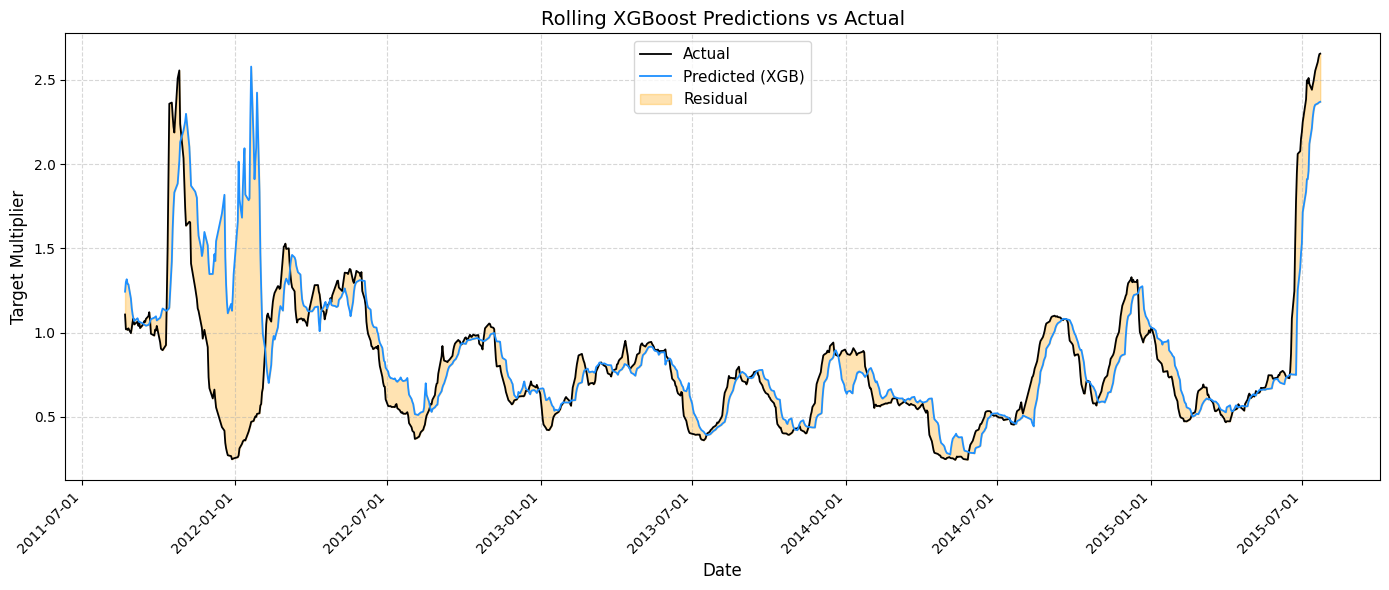

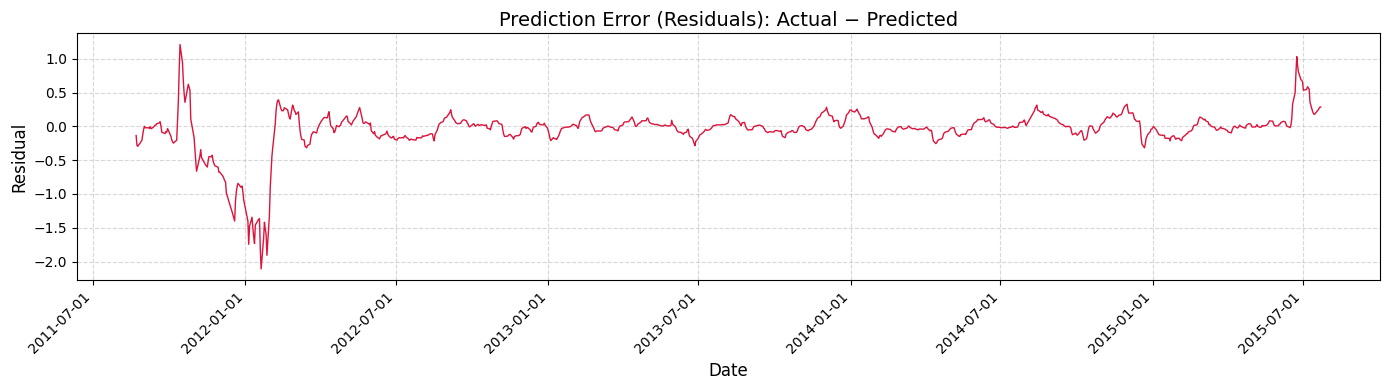

HAR*XGB MSE: 0.000000001401570 | R²: 0.6374


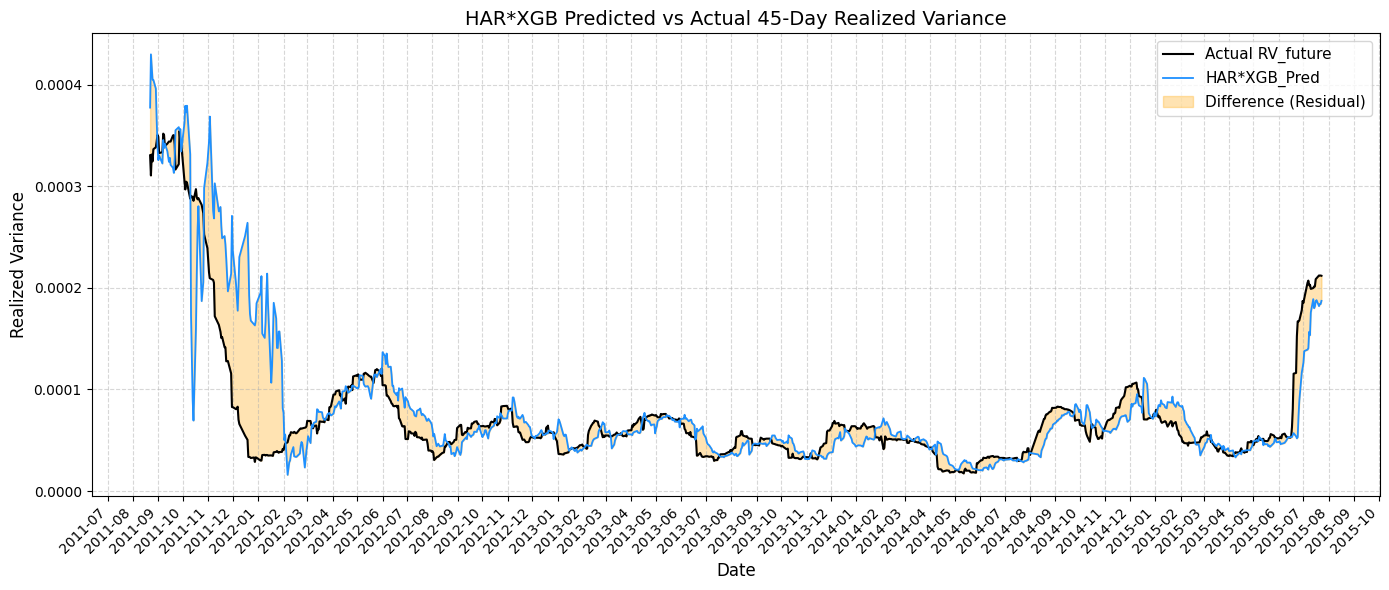

In [356]:
import matplotlib.dates as mdates

pred_df_spy_var = pred_df_spy_var_pca.copy()
print(pred_df_spy_var.head())
#   Smooth predictions by exponential moving average
pred_df_spy_var["Predicted"] = pred_df_spy_var["Predicted"].ewm(span=5, adjust=False).mean()
# Check date of har_pred
# Index spy by Date

# Merge by date column
pred_df_spy_var = pred_df_spy_var.merge(
    spy[["HAR_Pred"]],
    left_index=True,
    right_index=True,
    how="left"
)

# Compute metrics
print(pred_df_spy_var.head())
mse = mean_squared_error(pred_df_spy_var["Actual"], pred_df_spy_var["Predicted"])
mape = np.mean(np.abs((pred_df_spy_var["Actual"] - pred_df_spy_var["Predicted"]) / pred_df_spy_var["Actual"])) * 100

r2 = r2_score(pred_df_spy_var["Actual"], pred_df_spy_var["Predicted"])
print(f"MSE: {mse:.6f} | R²: {r2:.4f} | MAPE: {mape:.2f}%")


plt.figure(figsize=(14, 6))
plt.plot(pred_df_spy_var.index, pred_df_spy_var["Actual"], label="Actual", color="black", linewidth=1.3)
plt.plot(pred_df_spy_var.index, pred_df_spy_var["Predicted"], label="Predicted (XGB)", color="dodgerblue", linewidth=1.3)
plt.fill_between(
    pred_df_spy_var.index,
    pred_df_spy_var["Actual"],
    pred_df_spy_var["Predicted"],
    color="orange",
    alpha=0.3,
    label="Residual"
)

plt.title("Rolling XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Target Multiplier", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Residual plot
plt.figure(figsize=(14, 4))
residuals = pred_df_spy_var["Actual"] - pred_df_spy_var["Predicted"]
plt.plot(pred_df_spy_var.index, residuals, color="crimson", linewidth=1)
plt.title("Prediction Error (Residuals): Actual − Predicted", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Residual", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Calculate HAR*Pred to get actual variance prediction
pred_df_spy_var["HAR_XGB_Pred"] = pred_df_spy_var["HAR_Pred"] * pred_df_spy_var["Predicted"]
mse_har_xgb = mean_squared_error(spy.loc[pred_df_spy_var.index, "RV_future"], pred_df_spy_var["HAR_XGB_Pred"])
r2_har_xgb = r2_score(spy.loc[pred_df_spy_var.index, "RV_future"], pred_df_spy_var["HAR_XGB_Pred"])
print(f"HAR*XGB MSE: {mse_har_xgb:.15f} | R²: {r2_har_xgb:.4f}")
# -----------------------------------------
# Plot HAR*XGB vs RV_future and difference
plt.figure(figsize=(14, 6))
plt.plot(spy.loc[pred_df_spy_var.index].index, spy.loc[pred_df_spy_var.index, "RV_future"], label="Actual RV_future", color="black", linewidth=1.5)
plt.plot(pred_df_spy_var.index, pred_df_spy_var["HAR_XGB_Pred"], label="HAR*XGB_Pred", color="dodgerblue", linewidth=1.3)
plt.fill_between(
    pred_df_spy_var.index, 
    spy.loc[pred_df_spy_var.index, "RV_future"], 
    pred_df_spy_var["HAR_XGB_Pred"],
    color="orange", alpha=0.3, label="Difference (Residual)"
)
plt.title("HAR*XGB Predicted vs Actual 45-Day Realized Variance", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Realized Variance", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Covariance Calculation

In [ ]:
from volo_tools import volo_feature_impl_v2
importlib.reload(volo_feature_impl_v2)
import importlib
import pandas as pd
import glob
import os
import numpy as np
importlib.reload(volo_feature_impl)
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from volo_tools import volo_model 

train_window = 500
steps = 30
smoothing_window = 5
feature_processor = volo_feature_impl_v2.VoloFeatureImplV2()

index = "SPY"
index_df = feature_processor.feature_process_var_index(index, future_window=45)
# Get target_variance_index_multiplier as y and keep as data frame and indexed by date
# Copy first into y_index with date index
print(index_df.head())
y_index = index_df["target_variance_index_multiplier"].to_frame()
y_index.index = index_df.index
# remove anything with any text with future in the column name
X_index = index_df.loc[:, 
    ~index_df.columns.str.contains('Future', case=False) &
    ~index_df.columns.str.contains('target', case=False)
]
X_index.dropna(inplace=True)
print(X_index.head())

csv_files = glob.glob(os.path.join("data/", "*.csv"))
valid_symbols = [os.path.basename(f).replace("_data.csv", "") for f in csv_files if pd.read_csv(f).shape[0] > 1300]
x_data = feature_processor.feature_collector(valid_symbols)

# Merge X with x_data on index and preserve index
X_index = pd.merge(
    X_index, x_data, left_index=True, right_index=True, how="left"
)
model_processor = volo_model.VoloModel()
var_index_pred = model_processor.rolling_xgb_pca_fold(
    x_data,
    y_index,
    train_window=train_window,
    step=5,
    fold_interval=5,
    low_importance_ratio=0.3,
    n_pca_components=3
)



            HAR_Pred  target_variance_index_multiplier
Date                                                  
2010-05-12  0.000149                          1.744695
2010-05-13  0.000145                          1.783744
2010-05-14  0.000147                          1.747158
2010-05-17  0.000144                          1.804784
2010-05-18  0.000146                          1.832502
            HAR_Pred
Date                
2010-05-12  0.000149
2010-05-13  0.000145
2010-05-14  0.000147
2010-05-17  0.000144
2010-05-18  0.000146


C:\Users\likapichu\AppData\Local\Temp\ipykernel_27520\2975571772.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_index.dropna(inplace=True)
e:\voloridge\volo_tools\volo_feature_impl_v2.py:166: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  # remove anything with any text with future in the column name



[PCA Fold] Window 520: Combining 386 low-importance features into 3 PCA components

[PCA Fold] Window 545: Combining 271 low-importance features into 3 PCA components

[PCA Fold] Window 570: Combining 191 low-importance features into 3 PCA components

[PCA Fold] Window 595: Combining 134 low-importance features into 3 PCA components

[PCA Fold] Window 620: Combining 95 low-importance features into 3 PCA components

[PCA Fold] Window 645: Combining 67 low-importance features into 3 PCA components

[PCA Fold] Window 670: Combining 48 low-importance features into 3 PCA components

[PCA Fold] Window 695: Combining 35 low-importance features into 3 PCA components

[PCA Fold] Window 720: Combining 25 low-importance features into 3 PCA components

[PCA Fold] Window 745: Combining 18 low-importance features into 3 PCA components

[PCA Fold] Window 770: Combining 14 low-importance features into 3 PCA components

[PCA Fold] Window 795: Combining 11 low-importance features into 3 PCA components


In [424]:
var_index_pred_df = var_index_pred[0]

# Use har_pred to get actual variance prediction as data frame
var_index_pred_df = var_index_pred_df.merge(
    index_df[["HAR_Pred"]],
    left_index=True,
    right_index=True,
    how="left"
)
var_index_pred_df["Predicted_Index_Var"] = var_index_pred_df["Predicted"] * var_index_pred_df["HAR_Pred"]

In [ ]:


stock = "GM"
future_window = 45
merged_df = feature_processor.feature_process_var_corr(index, stock, future_window)

# keep as data frame for y
y_covar = merged_df[f"Future_Cov_45_{stock}"]
y_correlation = merged_df[f"target_correlation"]
y_variance = merged_df[f"target_variance"]
# Turn into series dataframe
y_covar = y_covar.to_frame()
y_correlation = y_correlation.to_frame()
y_variance = y_variance.to_frame()

print(y_correlation.head())


# remove anything with any text with future in the column name
X = merged_df.loc[:, 
    ~merged_df.columns.str.contains('Future', case=False) &
    ~merged_df.columns.str.contains('target', case=False)
]
X.dropna(inplace=True)
print(X.head())

csv_files = glob.glob(os.path.join("data/", "*.csv"))
valid_symbols = [os.path.basename(f).replace("_data.csv", "") for f in csv_files if pd.read_csv(f).shape[0] > 1300]
x_data = feature_processor.feature_collector(valid_symbols)

# Merge X with x_data on index and preserve index
X = pd.merge(
    X, x_data, left_index=True, right_index=True, how="left"
)

print(X.head())
# Print dimensions of X
print(f"Feature matrix shape: {X.shape}")






In [ ]:


stock = "GM"
future_window = 45
merged_df = feature_processor.feature_process_var_corr(index, stock, future_window)

# keep as data frame for y
y_covar = merged_df[f"Future_Cov_45_{stock}"]
y_correlation = merged_df[f"target_correlation"]
y_variance = merged_df[f"target_variance"]
# Turn into series dataframe
y_covar = y_covar.to_frame()
y_correlation = y_correlation.to_frame()
y_variance = y_variance.to_frame()

print(y_correlation.head())


# remove anything with any text with future in the column name
X = merged_df.loc[:, 
    ~merged_df.columns.str.contains('Future', case=False) &
    ~merged_df.columns.str.contains('target', case=False)
]
X.dropna(inplace=True)
print(X.head())

csv_files = glob.glob(os.path.join("data/", "*.csv"))
valid_symbols = [os.path.basename(f).replace("_data.csv", "") for f in csv_files if pd.read_csv(f).shape[0] > 1300]
x_data = feature_processor.feature_collector(valid_symbols)

# Merge X with x_data on index and preserve index
X = pd.merge(
    X, x_data, left_index=True, right_index=True, how="left"
)

print(X.head())
# Print dimensions of X
print(f"Feature matrix shape: {X.shape}")






In [ ]:
from volo_tools import volo_model
importlib.reload(volo_model)


model_processor = volo_model.VoloModel()
corrpred_df = model_processor.rolling_xgb_pca_fold(
    x_data,
    y_correlation,
    train_window=train_window,
    step=5,
    fold_interval=5,
    low_importance_ratio=0.3,
    n_pca_components=3
)



[PCA Fold] Window 520: Combining 386 low-importance features into 3 PCA components

[PCA Fold] Window 545: Combining 271 low-importance features into 3 PCA components

[PCA Fold] Window 570: Combining 191 low-importance features into 3 PCA components

[PCA Fold] Window 595: Combining 134 low-importance features into 3 PCA components

[PCA Fold] Window 620: Combining 95 low-importance features into 3 PCA components

[PCA Fold] Window 645: Combining 67 low-importance features into 3 PCA components

[PCA Fold] Window 670: Combining 48 low-importance features into 3 PCA components

[PCA Fold] Window 695: Combining 35 low-importance features into 3 PCA components

[PCA Fold] Window 720: Combining 25 low-importance features into 3 PCA components

[PCA Fold] Window 745: Combining 18 low-importance features into 3 PCA components

[PCA Fold] Window 770: Combining 14 low-importance features into 3 PCA components

[PCA Fold] Window 795: Combining 11 low-importance features into 3 PCA components


              Actual  Predicted
Date                           
2013-05-10  1.313862   1.258210
2013-05-13  1.336000   1.258210
2013-05-14  1.326892   1.258208
2013-05-15  1.322829   1.258201
2013-05-16  1.325793   1.258181
...              ...        ...
2015-07-20  1.281640   1.001590
2015-07-21  1.272394   1.012088
2015-07-22  1.269097   1.022885
2015-07-23  1.397399   1.033775
2015-07-24  1.401870   1.044552

[550 rows x 2 columns]
              Actual  Predicted  HAR_Pred_Corr_GM  Future_Corr_45_GM  \
Date                                                                   
2013-05-10  1.313862   1.258210          0.609517           0.800821   
2013-05-13  1.336000   1.258210          0.606981           0.810926   
2013-05-14  1.326892   1.258210          0.609542           0.808797   
2013-05-15  1.322829   1.258207          0.608467           0.804898   
2013-05-16  1.325793   1.258198          0.609390           0.807925   

            Predicted_Corr  Actual_Corr  
Date         

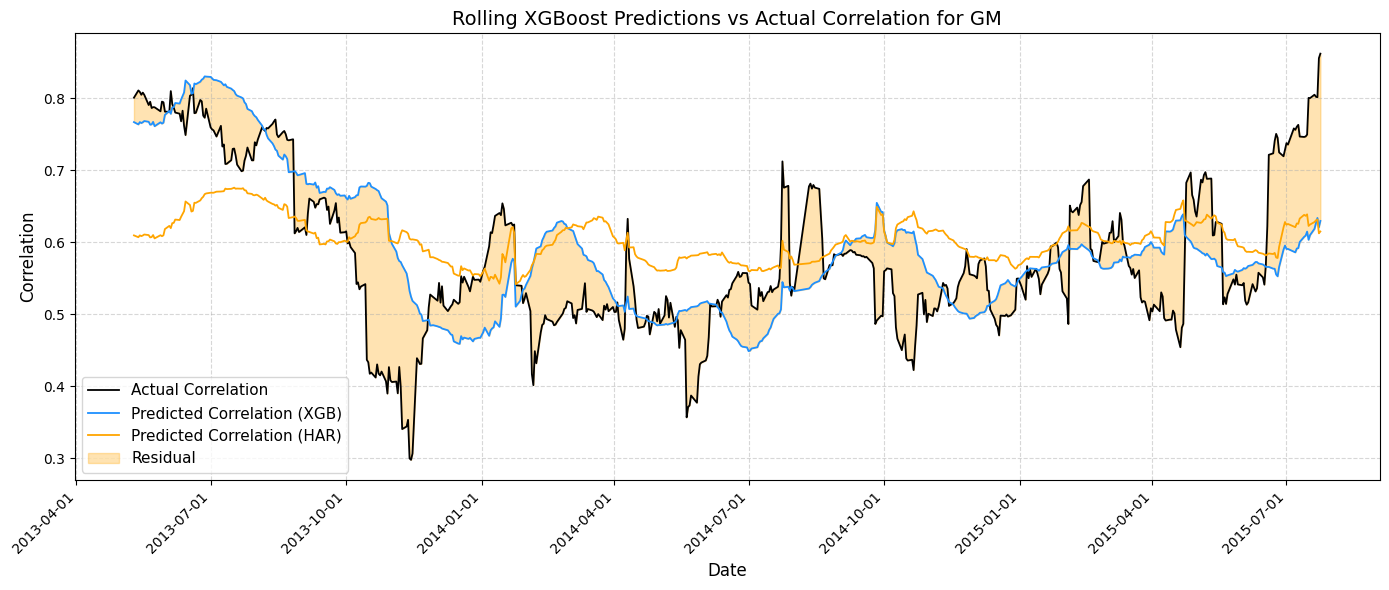

In [412]:
print(corrpred_df[0])

# Smooth predictions by exponential moving average
corrpred_df[0]["Predicted"] = corrpred_df[0]["Predicted"].ewm(span=5, adjust=False).mean()

# From the merged_df, get the correlation for the stock by multiplying correlation with HAR_Pred_Corr_{stock} into new dataframe
pred_converted_corr = pd.DataFrame()
# Merge first
pred_converted_corr = pd.merge(
    corrpred_df[0],
    merged_df[[f"HAR_Pred_Corr_{stock}"]],
    left_index=True,
    right_index=True,
    how="left"
)
# Merge again with 
pred_converted_corr = pd.merge(
    pred_converted_corr,
    merged_df[[f"Future_Corr_45_{stock}"]],
    left_index=True,
    right_index=True,
    how="left"
)
pred_converted_corr["Predicted_Corr"] = pred_converted_corr["Predicted"] * pred_converted_corr[f"HAR_Pred_Corr_{stock}"]
pred_converted_corr["Actual_Corr"] = merged_df[f"Future_Corr_45_{stock}"]
print(pred_converted_corr.head())
mse_corr = mean_squared_error(pred_converted_corr["Actual_Corr"], pred_converted_corr["Predicted_Corr"])
r2_corr = r2_score(pred_converted_corr["Actual_Corr"], pred_converted_corr["Predicted_Corr"])
print(f"Correlation MSE: {mse_corr:.6f} | R²: {r2_corr:.4f}")


# Graph the results
plt.figure(figsize=(14, 6))
plt.plot(pred_converted_corr.index, pred_converted_corr["Actual_Corr"], label="Actual Correlation", color="black", linewidth=1.3)
plt.plot(pred_converted_corr.index, pred_converted_corr["Predicted_Corr"], label="Predicted Correlation (XGB)", color="dodgerblue", linewidth=1.3)
# plot har prediction as well
plt.plot(pred_converted_corr.index, pred_converted_corr[f"HAR_Pred_Corr_{stock}"], label="Predicted Correlation (HAR)", color="orange", linewidth=1.3)
plt.fill_between(
    pred_converted_corr.index,
    pred_converted_corr["Actual_Corr"],
    pred_converted_corr["Predicted_Corr"],
    color="orange",
    alpha=0.3,
    label="Residual"
)
plt.title(f"Rolling XGBoost Predictions vs Actual Correlation for {stock}", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Correlation", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
from volo_tools import volo_model
importlib.reload(volo_model)
model_processor = volo_model.VoloModel()

varpred_df = model_processor.rolling_xgb_pca_fold(
    x_data,
    y_variance,
    train_window=train_window,
    step=5,
    fold_interval=5,
    low_importance_ratio=0.3,
    n_pca_components=3
)



[PCA Fold] Window 520: Combining 386 low-importance features into 3 PCA components

[PCA Fold] Window 545: Combining 271 low-importance features into 3 PCA components

[PCA Fold] Window 570: Combining 191 low-importance features into 3 PCA components

[PCA Fold] Window 595: Combining 134 low-importance features into 3 PCA components

[PCA Fold] Window 620: Combining 95 low-importance features into 3 PCA components

[PCA Fold] Window 645: Combining 67 low-importance features into 3 PCA components

[PCA Fold] Window 670: Combining 48 low-importance features into 3 PCA components

[PCA Fold] Window 695: Combining 35 low-importance features into 3 PCA components

[PCA Fold] Window 720: Combining 25 low-importance features into 3 PCA components

[PCA Fold] Window 745: Combining 18 low-importance features into 3 PCA components

[PCA Fold] Window 770: Combining 14 low-importance features into 3 PCA components

[PCA Fold] Window 795: Combining 11 low-importance features into 3 PCA components


              Actual  Predicted
Date                           
2013-05-10  0.948577   1.022898
2013-05-13  0.914786   1.031012
2013-05-14  0.900348   1.029360
2013-05-15  0.853966   1.044271
2013-05-16  0.866392   1.019337
...              ...        ...
2015-07-20  1.170286   1.143858
2015-07-21  1.184048   1.098784
2015-07-22  1.194599   1.122413
2015-07-23  1.024806   1.116033
2015-07-24  1.068008   1.113700

[550 rows x 2 columns]
            Predicted_Var  Actual_Var  HAR_Pred_Var_GM
Date                                                  
2013-05-10       0.000295    0.000274         0.000288
2013-05-13       0.000299    0.000267         0.000292
2013-05-14       0.000302    0.000265         0.000294
2013-05-15       0.000310    0.000257         0.000301
2013-05-16       0.000305    0.000257         0.000297
Variance MSE: 0.000000002074574 | R²: 0.5797


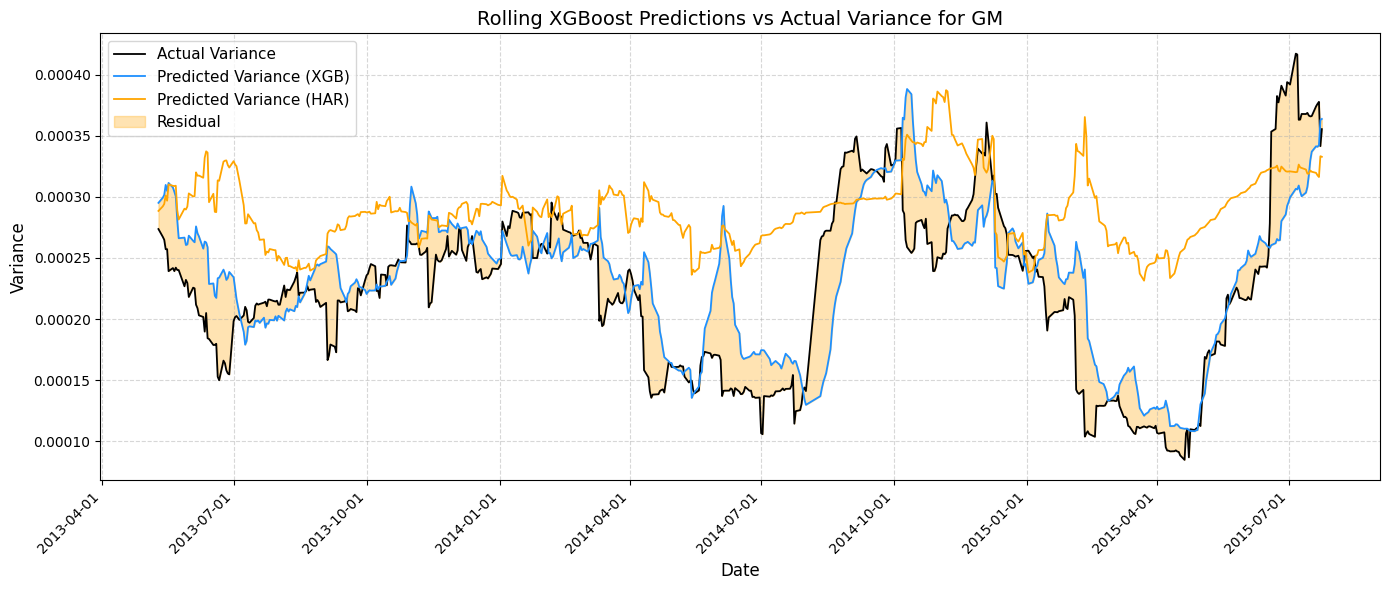

In [ ]:
print(varpred_df[0])

# Smooth predictions by exponential moving average
varpred_df[0]["Predicted"] = varpred_df[0]["Predicted"].ewm(span=10, adjust=False).mean()

# From the merged_df, get the correlation for the stock by multiplying correlation with HAR_Pred_Corr_{stock} into new dataframe
pred_converted = pd.DataFrame()
# Merge first
pred_converted = pd.merge(
    varpred_df[0],
    merged_df[[f"HAR_Pred_Var_{stock}"]],
    left_index=True,
    right_index=True,
    how="left"
)
# Merge again with 
pred_converted = pd.merge(
    pred_converted,
    merged_df[[f"Future_Var_45_{stock}"]],
    left_index=True,
    right_index=True,
    how="left"
)

pred_converted["Predicted_Var"] = pred_converted["Predicted"] * pred_converted[f"HAR_Pred_Var_{stock}"]
pred_converted["Actual_Var"] = merged_df[f"Future_Var_45_{stock}"]
print(pred_converted[["Predicted_Var", "Actual_Var", f"HAR_Pred_Var_{stock}"]].head())
mse_var = mean_squared_error(pred_converted["Actual_Var"], pred_converted["Predicted_Var"])
r2_var = r2_score(pred_converted["Actual_Var"], pred_converted["Predicted_Var"])
print(f"Variance MSE: {mse_var:.15f} | R²: {r2_var:.4f}")


# Graph the results
plt.figure(figsize=(14, 6))
plt.plot(pred_converted.index, pred_converted["Actual_Var"], label="Actual Variance", color="black", linewidth=1.3)
plt.plot(pred_converted.index, pred_converted["Predicted_Var"], label="Predicted Variance (XGB)", color="dodgerblue", linewidth=1.3)
# plot har prediction as well
plt.plot(pred_converted.index, pred_converted[f"HAR_Pred_Var_{stock}"], label="Predicted Variance (HAR)", color="orange", linewidth=1.3)
plt.fill_between(
    pred_converted.index,
    pred_converted["Actual_Var"],
    pred_converted["Predicted_Var"],
    color="orange",
    alpha=0.3,
    label="Residual"
)
plt.title(f"Rolling XGBoost Predictions vs Actual Variance for {stock}", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Variance", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
# Merge pred_df_spy_var and corrpred_df (The stock correlation to SPY) and varpred_df (the stock var) to get covariance prediction
print(pred_converted_corr)
final_pred = pd.DataFrame()
final_pred = pd.merge(
    var_index_pred_df[["Predicted_Index_Var"]],
    pred_converted_corr[["Predicted_Corr"]],
    left_index=True,
    right_index=True,
    how="left",
)
final_pred = pd.merge(
    final_pred,
    pred_converted[["Predicted_Var"]],
    left_index=True,
    right_index=True,
    how="left",
)
print(final_pred.head())
final_pred["Predicted_Covariance"] = np.sqrt(final_pred["Predicted_Index_Var"]) * final_pred["Predicted_Corr"] * np.sqrt(final_pred["Predicted_Var"])
final_pred = pd.merge(
    final_pred,
    merged_df[[f"Future_Cov_45_{stock}"]],
    left_index=True,
    right_index=True,
    how="left"
)
# Merge in , f"Future_Beta_45d"]
final_pred = pd.merge(
    final_pred,
    merged_df[[f"Future_Beta_45d"]],
    left_index=True,
    right_index=True,
    how="left"
)
print(final_pred)
# Calculate beta
final_pred["Beta_Predicted"] = final_pred["Predicted_Covariance"] / final_pred["Predicted_Index_Var"]

final_pred.to_csv(f"results/predicted_covariance_{stock}.csv")
# drop any na
final_pred.dropna(inplace=True)
mse_cov = mean_squared_error(final_pred[f"Future_Cov_45_{stock}"], final_pred["Predicted_Covariance"])
r2_cov = r2_score(final_pred[f"Future_Cov_45_{stock}"], final_pred["Predicted_Covariance"])
print(f"Covariance MSE: {mse_cov:.15f} | R²: {r2_cov:.4f}")
# -----------------------------------
# Plot HAR Predicted vs RV_future and difference
plt.figure(figsize=(14, 6))
plt.plot(final_pred.index, final_pred[f"Future_Cov_45_{stock}"], label="Actual Covariance", color="black", linewidth=1.5)
plt.plot(final_pred.index, final_pred["Predicted_Covariance"], label="Predicted Covariance (XGB)", color="dodgerblue", linewidth=1.3)
plt.fill_between(
    final_pred.index, 
    final_pred[f"Future_Cov_45_{stock}"], 
    final_pred["Predicted_Covariance"],
    color="orange", alpha=0.3, label="Difference (Residual)"
)
plt.title(f"Predicted vs Actual 45-Day Covariance between {stock} and {index}", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Covariance", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

              Actual  Predicted  HAR_Pred_Corr_GM  Future_Corr_45_GM  \
Date                                                                   
2013-05-10  1.313862   1.258210          0.609517           0.800821   
2013-05-13  1.336000   1.258210          0.606981           0.810926   
2013-05-14  1.326892   1.258210          0.609542           0.808797   
2013-05-15  1.322829   1.258207          0.608467           0.804898   
2013-05-16  1.325793   1.258198          0.609390           0.807925   
...              ...        ...               ...                ...   
2015-07-20  1.281640   0.984899          0.628070           0.804959   
2015-07-21  1.272394   0.993962          0.630397           0.802114   
2015-07-22  1.269097   1.003603          0.631491           0.801423   
2015-07-23  1.397399   1.013660          0.612371           0.855726   
2015-07-24  1.401870   1.023958          0.614912           0.862026   

            Predicted_Corr  Actual_Corr  
Date                 

KeyError: "['Future_Beta_45d'] not in index"